<a href="https://colab.research.google.com/github/wfreinhart/sdmm-regression/blob/main/notebooks/figure6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# make chart from precomputed data file

In [ ]:
import json

with open('metrics-kmers.json', 'r') as fid:
    metrics = json.load(fid)

In [ ]:
plottable_metrics = {}
model_keys = list(metrics['1'].keys())
t = 'rmse'
for short_name in model_keys:
    this = {}
    for s in ['train', 'test']:
        this[s] = np.array([[m[t] for m in metrics[str(L)][short_name][s]] for L in range(1, 11)])
    plottable_metrics[short_name] = this

## draw charts

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.font_manager as font_manager
sc = 1.5
matplotlib.rcParams['font.family'] = 'Open Sans'  # the font name
matplotlib.rcParams['font.size'] = 8*sc                   # the font size
font_manager._rebuild()  # this is a hack to fix something in Google Colab

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


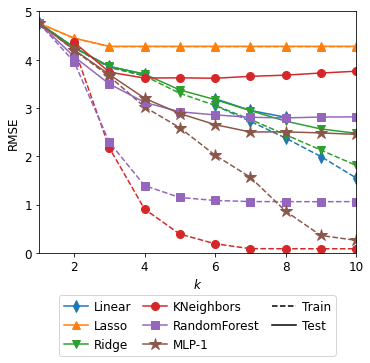

In [ ]:
import numpy as np

all_sigma = np.zeros(0)

t = 'rmse'
style_list = ['d', '^', 'v', 'o', 's', '*']
size_list = [8, 8, 8, 8, 8, 12]
fig, ax = plt.subplots(figsize=(3.54*sc, 3.54*sc))
for s in ['train', 'test']:
  # key = "<class 'sklearn.linear_model._base.LinearRegression'>"
  for i, key in enumerate(model_keys):
    mu = np.mean(plottable_metrics[key][s], axis=1)
    sigma = np.mean(plottable_metrics[key][s], axis=1)
    # remove bad points
    mu[mu > 5] = np.nan
    #
    short_key = key.split('.')[-1].split("'")[0].replace("Regressor", "").replace("Regression", "")
    if short_key == 'MLP':
        short_key = 'MLP-1'
    plot_x = np.arange(10)+1

    if s == 'train':
      ls = '--'
      mf = 'none'
    else:
      ls = '-'
      mf = cm.tab10(i)
      ax.plot(np.nan, np.nan, linestyle='-', color=cm.tab10(i),
              marker=style_list[i], ms=size_list[i], label=short_key)

    ax.plot(plot_x, mu, color=cm.tab10(i), linestyle=ls, marker=style_list[i], ms=size_list[i])

ax.plot(np.nan, np.nan, 'k--', label='Train')
ax.plot(np.nan, np.nan, 'k-', label='Test')

ax.set_ylim([0, 5])
ax.set_xlim([1, 10])

ax.set_xlabel('$k$')
ax.set_ylabel(f'RMSE')
# set ticks
ticks = ax.get_xticks()
ticklabels = [f'{int(x):d}' if x != 0 else 'Full' for x in ticks]
_ = ax.set_xticklabels(ticklabels)
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, numpoints=1, handletextpad=0.5, columnspacing=1.0)
fig.tight_layout()

In [ ]:
fig.savefig('fig6.pdf', bbox_inches='tight', pad_inches=0.05)

# create json data file

## code for counting k-mer tokens

In [ ]:
import itertools
import tqdm.notebook
from math import factorial
import numpy as np


def swap_monomers(seq):
    seq = seq.replace('A', 'C')
    seq = seq.replace('B', 'A')
    seq = seq.replace('C', 'B')
    return seq


def make_base(degree):
    # construct unique numbers of A/B monomers
    base = []
    for i in range(degree+1):
        for j in range(i):
            seq = ''.join(['A' for _ in range(i-j)] + ['B' for _ in range(j)])
            # print((i, j), seq)
            base += [''.join(x) for x in itertools.permutations(seq)]
            base += [''.join(x) for x in itertools.permutations(swap_monomers(seq))]
    base = sorted(set(base))
    pruned_base = []
    for b in base:
        if b not in pruned_base and b[::-1] not in pruned_base:
            pruned_base.append(b)
    base = pruned_base
    print(f'Finding {len(base)} patterns:', base)

    return base


def featurize(chain_sequences, base):
    X = np.zeros([len(chain_sequences), len(base)])
    for i, chain in tqdm.notebook.tqdm(enumerate(chain_sequences), total=len(chain_sequences)):
        if 'A' in str(chain):
            seq = chain
        else:
            seq = ''.join(['A' if x == 0 else 'B' for x in chain])
        X[i] = 0.5 * (np.array([seq.count(b) for b in base]) + np.array([seq[::-1].count(b) for b in base]))
    return X

In [ ]:
import numpy as np
import pandas as pd
import json

with open('data-10-folds.json', 'r') as fid:
    buffer = json.load(fid)

X = np.array(buffer['X'])
y = np.array(buffer['y'])

fold_data = []
for fold in buffer['folds']:
    train_index = np.array(fold['train'])
    test_index = np.array(fold['test'])

    trainX, testX = X[train_index], X[test_index]
    trainy, testy = y[train_index], y[test_index]
    
    fold_data.append({'train': {'X': trainX, 'y': trainy},
                      'test': {'X': testX, 'y': testy}
                      })

In [ ]:
all_tokens = {}
for L in range(1, 11):
    base = make_base(degree=L)
    token_X = featurize(X, base)

    token_fold_data = []
    for fold in buffer['folds']:
        train_index = fold['train']
        test_index = fold['test']

        trainX, testX = token_X[train_index], token_X[test_index]
        trainy, testy = y[train_index], y[test_index]
        
        token_fold_data.append({'train': {'X': trainX, 'y': trainy},
                                'test': {'X': testX, 'y': testy}})
        
    all_tokens[L] = token_fold_data

Finding 2 patterns: ['A', 'B']


  0%|          | 0/2038 [00:00<?, ?it/s]

Finding 5 patterns: ['A', 'AA', 'AB', 'B', 'BB']


  0%|          | 0/2038 [00:00<?, ?it/s]

Finding 11 patterns: ['A', 'AA', 'AAA', 'AAB', 'AB', 'ABA', 'ABB', 'B', 'BAB', 'BB', 'BBB']


  0%|          | 0/2038 [00:00<?, ?it/s]

Finding 21 patterns: ['A', 'AA', 'AAA', 'AAAA', 'AAAB', 'AAB', 'AABA', 'AABB', 'AB', 'ABA', 'ABAB', 'ABB', 'ABBA', 'ABBB', 'B', 'BAAB', 'BAB', 'BABB', 'BB', 'BBB', 'BBBB']


  0%|          | 0/2038 [00:00<?, ?it/s]

Finding 41 patterns: ['A', 'AA', 'AAA', 'AAAA', 'AAAAA', 'AAAAB', 'AAAB', 'AAABA', 'AAABB', 'AAB', 'AABA', 'AABAA', 'AABAB', 'AABB', 'AABBA', 'AABBB', 'AB', 'ABA', 'ABAAB', 'ABAB', 'ABABA', 'ABABB', 'ABB', 'ABBA', 'ABBAB', 'ABBB', 'ABBBA', 'ABBBB', 'B', 'BAAAB', 'BAAB', 'BAABB', 'BAB', 'BABAB', 'BABB', 'BABBB', 'BB', 'BBABB', 'BBB', 'BBBB', 'BBBBB']


  0%|          | 0/2038 [00:00<?, ?it/s]

Finding 77 patterns: ['A', 'AA', 'AAA', 'AAAA', 'AAAAA', 'AAAAAA', 'AAAAAB', 'AAAAB', 'AAAABA', 'AAAABB', 'AAAB', 'AAABA', 'AAABAA', 'AAABAB', 'AAABB', 'AAABBA', 'AAABBB', 'AAB', 'AABA', 'AABAA', 'AABAAB', 'AABAB', 'AABABA', 'AABABB', 'AABB', 'AABBA', 'AABBAA', 'AABBAB', 'AABBB', 'AABBBA', 'AABBBB', 'AB', 'ABA', 'ABAAAB', 'ABAAB', 'ABAABA', 'ABAABB', 'ABAB', 'ABABA', 'ABABAB', 'ABABB', 'ABABBA', 'ABABBB', 'ABB', 'ABBA', 'ABBAAB', 'ABBAB', 'ABBABB', 'ABBB', 'ABBBA', 'ABBBAB', 'ABBBB', 'ABBBBA', 'ABBBBB', 'B', 'BAAAAB', 'BAAAB', 'BAAABB', 'BAAB', 'BAABAB', 'BAABB', 'BAABBB', 'BAB', 'BABAB', 'BABABB', 'BABB', 'BABBAB', 'BABBB', 'BABBBB', 'BB', 'BBAABB', 'BBABB', 'BBABBB', 'BBB', 'BBBB', 'BBBBB', 'BBBBBB']


  0%|          | 0/2038 [00:00<?, ?it/s]

Finding 149 patterns: ['A', 'AA', 'AAA', 'AAAA', 'AAAAA', 'AAAAAA', 'AAAAAAA', 'AAAAAAB', 'AAAAAB', 'AAAAABA', 'AAAAABB', 'AAAAB', 'AAAABA', 'AAAABAA', 'AAAABAB', 'AAAABB', 'AAAABBA', 'AAAABBB', 'AAAB', 'AAABA', 'AAABAA', 'AAABAAA', 'AAABAAB', 'AAABAB', 'AAABABA', 'AAABABB', 'AAABB', 'AAABBA', 'AAABBAA', 'AAABBAB', 'AAABBB', 'AAABBBA', 'AAABBBB', 'AAB', 'AABA', 'AABAA', 'AABAAAB', 'AABAAB', 'AABAABA', 'AABAABB', 'AABAB', 'AABABA', 'AABABAA', 'AABABAB', 'AABABB', 'AABABBA', 'AABABBB', 'AABB', 'AABBA', 'AABBAA', 'AABBAAB', 'AABBAB', 'AABBABA', 'AABBABB', 'AABBB', 'AABBBA', 'AABBBAA', 'AABBBAB', 'AABBBB', 'AABBBBA', 'AABBBBB', 'AB', 'ABA', 'ABAAAAB', 'ABAAAB', 'ABAAABA', 'ABAAABB', 'ABAAB', 'ABAABA', 'ABAABAB', 'ABAABB', 'ABAABBA', 'ABAABBB', 'ABAB', 'ABABA', 'ABABAAB', 'ABABAB', 'ABABABA', 'ABABABB', 'ABABB', 'ABABBA', 'ABABBAB', 'ABABBB', 'ABABBBA', 'ABABBBB', 'ABB', 'ABBA', 'ABBAAAB', 'ABBAAB', 'ABBAABB', 'ABBAB', 'ABBABAB', 'ABBABB', 'ABBABBA', 'ABBABBB', 'ABBB', 'ABBBA', 'ABBBAAB', '

  0%|          | 0/2038 [00:00<?, ?it/s]

Finding 285 patterns: ['A', 'AA', 'AAA', 'AAAA', 'AAAAA', 'AAAAAA', 'AAAAAAA', 'AAAAAAAA', 'AAAAAAAB', 'AAAAAAB', 'AAAAAABA', 'AAAAAABB', 'AAAAAB', 'AAAAABA', 'AAAAABAA', 'AAAAABAB', 'AAAAABB', 'AAAAABBA', 'AAAAABBB', 'AAAAB', 'AAAABA', 'AAAABAA', 'AAAABAAA', 'AAAABAAB', 'AAAABAB', 'AAAABABA', 'AAAABABB', 'AAAABB', 'AAAABBA', 'AAAABBAA', 'AAAABBAB', 'AAAABBB', 'AAAABBBA', 'AAAABBBB', 'AAAB', 'AAABA', 'AAABAA', 'AAABAAA', 'AAABAAAB', 'AAABAAB', 'AAABAABA', 'AAABAABB', 'AAABAB', 'AAABABA', 'AAABABAA', 'AAABABAB', 'AAABABB', 'AAABABBA', 'AAABABBB', 'AAABB', 'AAABBA', 'AAABBAA', 'AAABBAAA', 'AAABBAAB', 'AAABBAB', 'AAABBABA', 'AAABBABB', 'AAABBB', 'AAABBBA', 'AAABBBAA', 'AAABBBAB', 'AAABBBB', 'AAABBBBA', 'AAABBBBB', 'AAB', 'AABA', 'AABAA', 'AABAAAAB', 'AABAAAB', 'AABAAABA', 'AABAAABB', 'AABAAB', 'AABAABA', 'AABAABAA', 'AABAABAB', 'AABAABB', 'AABAABBA', 'AABAABBB', 'AABAB', 'AABABA', 'AABABAA', 'AABABAAB', 'AABABAB', 'AABABABA', 'AABABABB', 'AABABB', 'AABABBA', 'AABABBAA', 'AABABBAB', 'AABAB

  0%|          | 0/2038 [00:00<?, ?it/s]

Finding 557 patterns: ['A', 'AA', 'AAA', 'AAAA', 'AAAAA', 'AAAAAA', 'AAAAAAA', 'AAAAAAAA', 'AAAAAAAAA', 'AAAAAAAAB', 'AAAAAAAB', 'AAAAAAABA', 'AAAAAAABB', 'AAAAAAB', 'AAAAAABA', 'AAAAAABAA', 'AAAAAABAB', 'AAAAAABB', 'AAAAAABBA', 'AAAAAABBB', 'AAAAAB', 'AAAAABA', 'AAAAABAA', 'AAAAABAAA', 'AAAAABAAB', 'AAAAABAB', 'AAAAABABA', 'AAAAABABB', 'AAAAABB', 'AAAAABBA', 'AAAAABBAA', 'AAAAABBAB', 'AAAAABBB', 'AAAAABBBA', 'AAAAABBBB', 'AAAAB', 'AAAABA', 'AAAABAA', 'AAAABAAA', 'AAAABAAAA', 'AAAABAAAB', 'AAAABAAB', 'AAAABAABA', 'AAAABAABB', 'AAAABAB', 'AAAABABA', 'AAAABABAA', 'AAAABABAB', 'AAAABABB', 'AAAABABBA', 'AAAABABBB', 'AAAABB', 'AAAABBA', 'AAAABBAA', 'AAAABBAAA', 'AAAABBAAB', 'AAAABBAB', 'AAAABBABA', 'AAAABBABB', 'AAAABBB', 'AAAABBBA', 'AAAABBBAA', 'AAAABBBAB', 'AAAABBBB', 'AAAABBBBA', 'AAAABBBBB', 'AAAB', 'AAABA', 'AAABAA', 'AAABAAA', 'AAABAAAAB', 'AAABAAAB', 'AAABAAABA', 'AAABAAABB', 'AAABAAB', 'AAABAABA', 'AAABAABAA', 'AAABAABAB', 'AAABAABB', 'AAABAABBA', 'AAABAABBB', 'AAABAB', 'AAABABA', 

  0%|          | 0/2038 [00:00<?, ?it/s]

Finding 1085 patterns: ['A', 'AA', 'AAA', 'AAAA', 'AAAAA', 'AAAAAA', 'AAAAAAA', 'AAAAAAAA', 'AAAAAAAAA', 'AAAAAAAAAA', 'AAAAAAAAAB', 'AAAAAAAAB', 'AAAAAAAABA', 'AAAAAAAABB', 'AAAAAAAB', 'AAAAAAABA', 'AAAAAAABAA', 'AAAAAAABAB', 'AAAAAAABB', 'AAAAAAABBA', 'AAAAAAABBB', 'AAAAAAB', 'AAAAAABA', 'AAAAAABAA', 'AAAAAABAAA', 'AAAAAABAAB', 'AAAAAABAB', 'AAAAAABABA', 'AAAAAABABB', 'AAAAAABB', 'AAAAAABBA', 'AAAAAABBAA', 'AAAAAABBAB', 'AAAAAABBB', 'AAAAAABBBA', 'AAAAAABBBB', 'AAAAAB', 'AAAAABA', 'AAAAABAA', 'AAAAABAAA', 'AAAAABAAAA', 'AAAAABAAAB', 'AAAAABAAB', 'AAAAABAABA', 'AAAAABAABB', 'AAAAABAB', 'AAAAABABA', 'AAAAABABAA', 'AAAAABABAB', 'AAAAABABB', 'AAAAABABBA', 'AAAAABABBB', 'AAAAABB', 'AAAAABBA', 'AAAAABBAA', 'AAAAABBAAA', 'AAAAABBAAB', 'AAAAABBAB', 'AAAAABBABA', 'AAAAABBABB', 'AAAAABBB', 'AAAAABBBA', 'AAAAABBBAA', 'AAAAABBBAB', 'AAAAABBBB', 'AAAAABBBBA', 'AAAAABBBBB', 'AAAAB', 'AAAABA', 'AAAABAA', 'AAAABAAA', 'AAAABAAAA', 'AAAABAAAAB', 'AAAABAAAB', 'AAAABAAABA', 'AAAABAAABB', 'AAAABAAB', 'AA

  0%|          | 0/2038 [00:00<?, ?it/s]